# 1. Load data

In [10]:
import pandas as pd

# 加载数据
df = pd.read_csv("../dataset/big_startup_secsees_dataset.csv")
print(df.shape)
df.head()

(66368, 14)


,permalink,name,homepage_url,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at
0,/organization/-fame,#fame,http://livfame.com,Media,10000000,operating,IND,16,Mumbai,Mumbai,1,NaN,2015-01-05,2015-01-05
1,/organization/-qounter,:Qounter,http://www.qounter.com,Application Platforms|Real Time|Social Network...,700000,operating,USA,DE,DE - Other,Delaware City,2,2014-09-04,2014-03-01,2014-10-14
2,/organization/-the-one-of-them-inc-,"(THE) ONE of THEM,Inc.",http://oneofthem.jp,Apps|Games|Mobile,3406878,operating,NaN,NaN,NaN,NaN,1,NaN,2014-01-30,2014-01-30
3,/organization/0-6-com,0-6.com,http://www.0-6.com,Curated Web,2000000,operating,CHN,22,Beijing,Beijing,1,2007-01-01,2008-03-19,2008-03-19
4,/organization/004-technologies,004 Technologies,http://004gmbh.de/en/004-interact,Software,-,operating,USA,IL,"Springfield, Illinois",Champaign,1,2010-01-01,2014-07-24,2014-07-24


# 2. check missing value

In [11]:
missing = df.isnull().sum()
missing[missing > 0].sort_values(ascending=False)

founded_at          15221
state_code           8547
region               8030
city                 8028
country_code         6958
homepage_url         5058
category_list        3148
first_funding_at       24
name                    1
dtype: int64

In [12]:
# 删除关键字段缺失值：公司成立时间、行业、国家
df_clean = df.dropna(subset=['founded_at', 'category_list', 'country_code'])

# 看看剩下多少行
print(f"原始行数: {df.shape[0]}")
print(f"清洗后行数: {df_clean.shape[0]}")

原始行数: 66368
清洗后行数: 46528


In [13]:
status_counts = df_clean['status'].value_counts(dropna=False)
status_percent = (status_counts / len(df_clean) * 100).round(2)

status_summary = pd.DataFrame({
    'Count': status_counts,
    'Percentage': status_percent
})

print(status_summary)


           Count  Percentage
status                      
operating  38084       81.85
acquired    4148        8.92
closed      3131        6.73
ipo         1165        2.50


In [14]:
df_clean['is_risky'] = df_clean['status'].apply(lambda x: 1 if x=='closed' else 0)
print(df_clean['is_risky'].value_counts(normalize=True).round(4))

is_risky
0    0.9327
1    0.0673
Name: proportion, dtype: float64


/var/folders/p4/7ssnbtxx5z7f5dxb1k188dc40000gn/T/ipykernel_68222/424447219.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['is_risky'] = df_clean['status'].apply(lambda x: 1 if x=='closed' else 0)


In [15]:
import numpy as np

# 复制数据
df_model = df_clean.copy()

# 提取成立年份
df_model['founded_year'] = pd.to_datetime(df_model['founded_at'], errors='coerce').dt.year

# 转换融资金额为 float，排除 "-", "" 等非法值
df_model['funding_total_usd'] = (
    df_model['funding_total_usd']
    .replace(['\$', ','], '', regex=True)  # 去掉美元符号和逗号
    .replace(['', '-'], np.nan)            # 把空字符串和横杠变成 NaN
    .astype(float)
)

# 选择字段
df_model = df_model[['country_code', 'category_list', 'founded_year', 'funding_total_usd', 'funding_rounds', 'is_risky']]

# 查看缺失值统计
print(df_model.isnull().sum())

country_code            0
category_list           0
founded_year            1
funding_total_usd    7479
funding_rounds          0
is_risky                0
dtype: int64


<>:12: SyntaxWarning: invalid escape sequence '\$'
<>:12: SyntaxWarning: invalid escape sequence '\$'
/var/folders/p4/7ssnbtxx5z7f5dxb1k188dc40000gn/T/ipykernel_68222/1780455475.py:12: SyntaxWarning: invalid escape sequence '\$'
  .replace(['\$', ','], '', regex=True)  # 去掉美元符号和逗号


In [16]:
# 删除 founded_year 缺失的那一行
df_model = df_model[df_model['founded_year'].notnull()]

# 用中位数填补 funding_total_usd 缺失
median_funding = df_model['funding_total_usd'].median()
df_model['funding_total_usd'] = df_model['funding_total_usd'].fillna(median_funding)

# 最终确认无缺失
print(df_model.isnull().sum())
print(f"最终样本数: {len(df_model)}")

country_code         0
category_list        0
founded_year         0
funding_total_usd    0
funding_rounds       0
is_risky             0
dtype: int64
最终样本数: 46527


In [17]:
from sklearn.preprocessing import OneHotEncoder

# --- 简化行业类别：只保留第一个标签 ---
df_model['main_category'] = df_model['category_list'].apply(lambda x: x.split('|')[0] if '|' in x else x)

# --- 简化国家：只保留前10个国家，其他设为 "Other" ---
top_countries = df_model['country_code'].value_counts().head(10).index
df_model['country_grouped'] = df_model['country_code'].apply(lambda x: x if x in top_countries else 'Other')

# --- One-Hot 编码 ---
df_encoded = pd.get_dummies(df_model[['country_grouped', 'main_category']], prefix=['country', 'category'])

# --- 拼接编码后的变量 + 数值型特征 ---
df_final = pd.concat([
    df_model[['founded_year', 'funding_total_usd', 'funding_rounds', 'is_risky']],
    df_encoded
], axis=1)

print("✅ 最终特征维度:", df_final.shape)

✅ 最终特征维度: (46527, 723)


In [19]:
from sklearn.model_selection import train_test_split

# 重新从 df_final 划分训练集和测试集
X = df_final.drop("is_risky", axis=1)
y = df_final["is_risky"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [20]:
from sklearn.utils import resample
import pandas as pd

# 合并 X 和 y 以便采样
train_data = pd.concat([X_train, y_train], axis=1)

# 分离多数类和少数类
majority = train_data[train_data.is_risky == 0]
minority = train_data[train_data.is_risky == 1]

# 下采样多数类
majority_downsampled = resample(
    majority,
    replace=False,
    n_samples=len(minority),
    random_state=42
)

# 合并平衡后的训练数据
train_balanced = pd.concat([majority_downsampled, minority])

# 分离特征和标签
X_train_bal = train_balanced.drop("is_risky", axis=1)
y_train_bal = train_balanced["is_risky"]

# 训练逻辑回归模型
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(max_iter=1000)
model.fit(X_train_bal, y_train_bal)

# 预测与评估
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]

from sklearn.metrics import classification_report, roc_auc_score
print(classification_report(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_proba))

              precision    recall  f1-score   support

           0       0.95      0.21      0.34      8680
           1       0.07      0.86      0.13       626

    accuracy                           0.25      9306
   macro avg       0.51      0.53      0.24      9306
weighted avg       0.89      0.25      0.33      9306

ROC AUC: 0.5673179134582824


In [21]:
import numpy as np
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix

# 1. 使用训练好的模型预测概率
y_proba = model.predict_proba(X_test)[:, 1]

# 2. 设置自定义阈值
threshold = 0.2  # 你可以试试 0.1 ~ 0.4 之间不同的阈值
y_pred_custom = (y_proba >= threshold).astype(int)

# 3. 打印评估指标
print("🎯 使用自定义阈值 =", threshold)
print(classification_report(y_test, y_pred_custom))
print("ROC AUC:", roc_auc_score(y_test, y_proba))

# 可选：查看混淆矩阵
print("📊 混淆矩阵：")
print(confusion_matrix(y_test, y_pred_custom))

🎯 使用自定义阈值 = 0.2
              precision    recall  f1-score   support

           0       1.00      0.01      0.01      8680
           1       0.07      1.00      0.13       626

    accuracy                           0.07      9306
   macro avg       0.53      0.50      0.07      9306
weighted avg       0.94      0.07      0.02      9306

ROC AUC: 0.5673179134582824
📊 混淆矩阵：
[[  50 8630]
 [   0  626]]


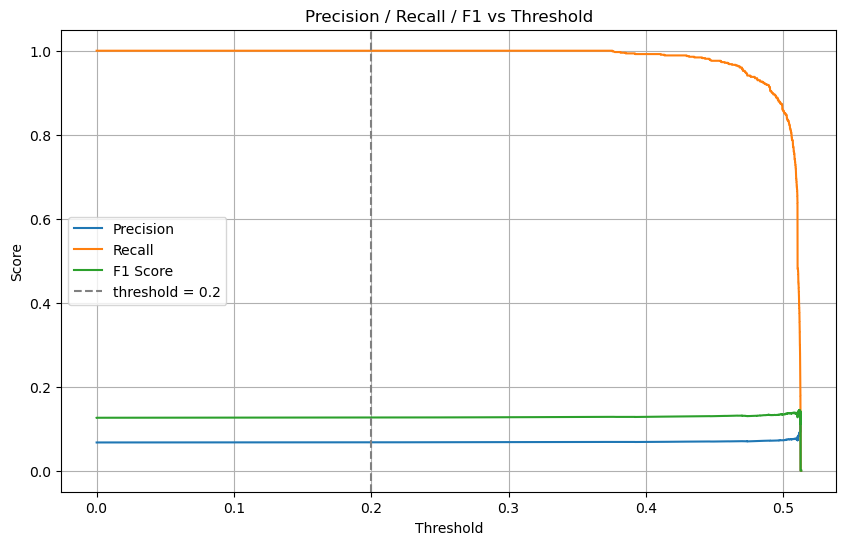

In [22]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve

precision, recall, thresholds = precision_recall_curve(y_test, y_proba)
f1 = 2 * (precision * recall) / (precision + recall + 1e-8)  # 避免除0

plt.figure(figsize=(10, 6))
plt.plot(thresholds, precision[:-1], label="Precision")
plt.plot(thresholds, recall[:-1], label="Recall")
plt.plot(thresholds, f1[:-1], label="F1 Score")
plt.axvline(x=0.2, color='gray', linestyle='--', label='threshold = 0.2')
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Precision / Recall / F1 vs Threshold")
plt.legend()
plt.grid()
plt.show()

In [25]:
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# 建模
lr = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42)
rf = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', scale_pos_weight=10)

# 融合模型（软投票，使用概率）
voting_clf = VotingClassifier(
    estimators=[('lr', lr), ('rf', rf), ('xgb', xgb)],
    voting='soft'
)

# 训练
voting_clf.fit(X_train, y_train)

# 预测
y_pred = voting_clf.predict(X_test)
y_proba = voting_clf.predict_proba(X_test)[:, 1]

# 评估
from sklearn.metrics import classification_report, roc_auc_score
print(classification_report(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_proba))

/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [21:38:40] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


              precision    recall  f1-score   support

           0       0.94      0.97      0.95      8680
           1       0.23      0.13      0.17       626

    accuracy                           0.91      9306
   macro avg       0.58      0.55      0.56      9306
weighted avg       0.89      0.91      0.90      9306

ROC AUC: 0.7078523210789005


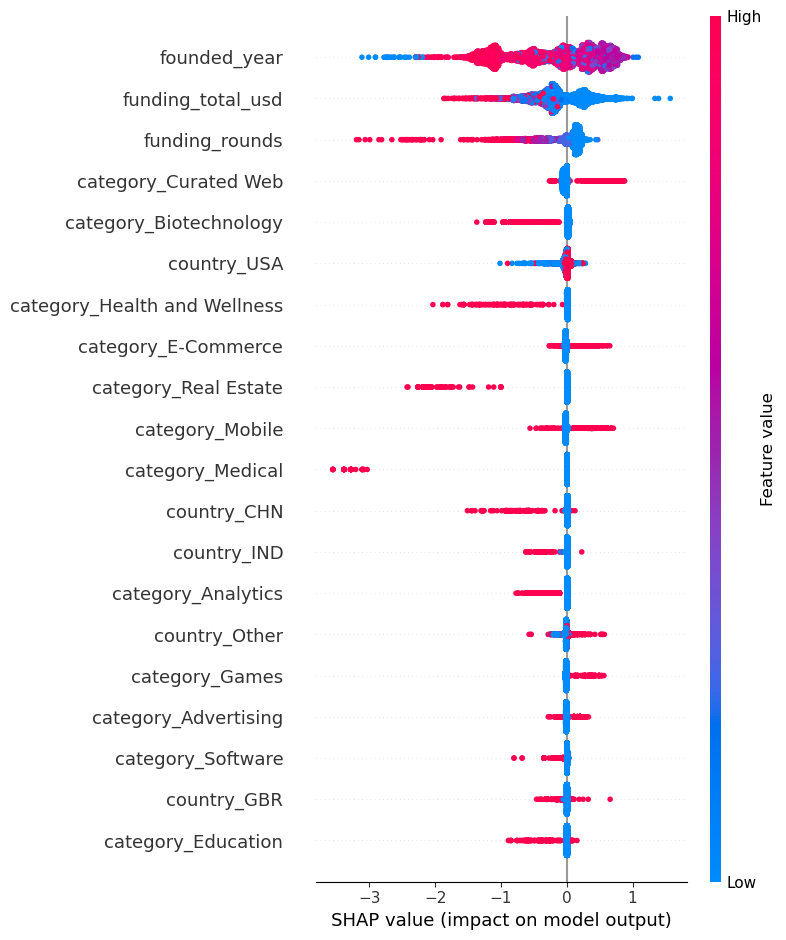

In [31]:
import shap
import xgboost as xgb
import numpy as np
import pandas as pd

# Step 1: 确保你拿的是训练后的 XGBoost 模型
xgb_model = voting_clf.named_estimators_["xgb"]

# Step 2: 检查并确认没有缺失值
assert not X_train.isnull().any().any(), " X_train 仍包含 NaN"
assert not X_test.isnull().any().any(), " X_test 仍包含 NaN"

# Step 3: 转换为 numpy 格式
X_train_np = X_train.values
X_test_np = X_test.values

# Step 4: 创建 SHAP Explainer
explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X_test_np)

# Step 5: 可视化特征重要性
shap.summary_plot(shap_values, X_test_np, feature_names=X_test.columns.tolist(), max_display=20)